# 2. 第二章 - 如何训练一个神经网络（简单版）


目录：

第一部分 神经网络
* 2.0 神经网络简介  

第二部分 线性回归
* 2.1 加载数据
* 2.2 定义模型
* 2.3 定义损失函数
* 2.4 选择优化器
* 2.5 训练模型并验证
* 2.6 附：可视化验证

## 2.0 神经网络简介

以监督学习为例，我们训练一个神经网络，目标是：给定输入数据及其正确的标签，将输入数据传入我们的神经网络中，通过神经网络的复杂计算，得到对应的输出值，使这个输出值尽可能地与正确标签相符。

为了实现上述目标，我们以这样一种简单的方式理解神经网络的训练流程：  
* 首先，我们拿到含有正确标签的数据（获取数据集）；  
* 然后，我们定义一系列含有待定参数的计算（定义神经网络，其参数就是我们的学习目标）；  
* 接着，我们将数据按照第二步定义好的规则，计算得到对应的输出值（前向传播）；  
* 随后，我们根据一定规则，比较输出值与正确标签的差异（计算损失函数）；  
* 最后，我们根据输出值与正确标签的差异大小，反观我们当前计算中所使用的各个参数，对参数进行优化更新（反向传播以及参数优化）；  
以此反复，优化我们的计算，最终寻找到该计算（神经网络）的最佳参数。

对应地，在 Jittor (计图) 中，我们可以按如下顺序训练一个神经网络：
1. 加载数据
2. 定义模型
3. 定义损失函数
4. 选择优化器
5. 训练模型（并验证）

现在，我们按照上述流程，实现一个简单的神经网络吧！（线性回归问题）

In [1]:
# 加载计图
import jittor as jt

# 开启 GPU 加速
# jt.flags.use_cuda = 1

[i 0202 22:58:27.866990 76 compiler.py:847] Jittor(1.2.2.27) src: /home/llt/.local/lib/python3.7/site-packages/jittor
[i 0202 22:58:27.869186 76 compiler.py:848] g++ at /usr/bin/g++
[i 0202 22:58:27.870261 76 compiler.py:849] cache_path: /home/llt/.cache/jittor/default/g++
[i 0202 22:58:27.886880 76 __init__.py:257] Found /usr/local/cuda/bin/nvcc(10.2.89) at /usr/local/cuda/bin/nvcc.
[i 0202 22:58:27.959711 76 __init__.py:257] Found gdb(8.1.0) at /usr/bin/gdb.
[i 0202 22:58:27.976226 76 __init__.py:257] Found addr2line(2.30) at /usr/bin/addr2line.
[i 0202 22:58:28.026845 76 compiler.py:889] pybind_include: -I/usr/include/python3.7m -I/usr/local/lib/python3.7/dist-packages/pybind11/include
[i 0202 22:58:28.051528 76 compiler.py:891] extension_suffix: .cpython-37m-x86_64-linux-gnu.so
[i 0202 22:58:28.245442 76 __init__.py:169] Total mem: 62.78GB, using 16 procs for compiling.
[i 0202 22:58:30.601735 76 jit_compiler.cc:21] Load cc_path: /usr/bin/g++
[i 0202 22:58:30.801683 76 init.cc:54] 

## 任务：线性回归问题

任务描述如下：  
* 已知 x 和 y 具有一定的线性关系。
* 给定 x 的值，用模型预测 y 的值。 

解决步骤如下：
* 首先，我们会随机生成一些具有线性关系的数据点 $(x, y)$，当作我们的数据集；  
* 然后，定义我们的计算模型为 $y=a + b \cdot x $；  
* 接着，我们用计图的内置函数，选择我们的损失函数和参数优化器；  
* 最后，我们将完成训练模型的主代码块以及验证部分的代码。

## 2.1 加载数据

首先，我们要准备好实验的数据集。 

在这个线性回归问题中，我们会随机生成 100 个数据点 $(x, y)$。其中，x 和 y 潜在的线性关系为 $y=a + b \cdot x $ （我们会为 $y$ 设置一定的噪音 ）。这里，$a$ 和 $b$ 为我们模型将要学习的参数。**我们先手动设置 $a = 1$，$b = 2$ 来生成数据集。然后，我们用这样一个数据集训练我们的模型，看看模型是否有能力学习到这两个参数值。**

In [2]:
import numpy as np

# 设定种子，保持结果的可复制性。
np.random.seed(2021)  

# 初始化 100 个数据点。其中，x 为输入数据，y 为正确的标签值（通过 x 预测的值）。
x = np.random.rand(100).reshape(100,1)
y = 1 + 2 * x + 0.1 * np.random.randn(100,1)             # 线性关系设置为 a = 1, b = 2,并利用正态分布，给 y 的值设定噪音

# 将我们的数据点，切分为训练集和验证集（先随机切分索引，再根据索引切分数据集）
index = np.arange(100)                                   # 生成 100 个索引值
np.random.shuffle(index)                                 # 将索引随机排序
train_index = index[:80]                                 # 训练集数据对应的索引
val_index = index[-20:]                                  # 验证集数据对应的索引

# 根据索引，切分训练集和验证集
x_train, y_train = x[train_index], y[train_index]
x_val, y_val = x[val_index], y[val_index]

将数据集准备好后，我们通过 Matplotlib 查看一下数据点的分布

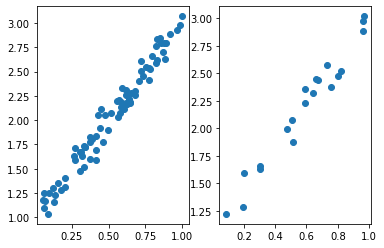

In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 1, ncols = 2)
axs[0].scatter(x_train, y_train)                         # 展示训练集上的数据点
axs[1].scatter(x_val, y_val)                             # 展示验证集上的数据点

最后，我们将数据点加载到 Jittor 中，转化为 Jittor 可操作的 Var 类型。

In [4]:
# 将 NumPy 数组转化成 Var
x_train_var = jt.array(x_train)
y_train_var = jt.array(y_train)
x_val_var = jt.array(x_val)
y_val_var = jt.array(y_val)

## 2.2 定义模型

模型的定义：我们定义模型需要继承 Jittor 的 Module 类，并实现  \_\_init__  函数和 execute 函数。
* \_\_init__ 函数： 用于定义模型由哪些参数或操作组成； 
* execute 函数： 定义了模型执行的顺序和模型的返回值。

In [6]:
"""
模型 1
"""
from jittor import Module

class FirstModel(Module):

    def __init__(self):
        super().__init__()

        # 随机初始化参数 a 和 b
        self.a = jt.rand(1)
        self.b = jt.rand(1) 

    def execute(self, x):
        # 模型通过输入的 x 值，进行与参数 a 和参数 b 的计算，得到预测的 y 值，并返回计算结果
        y_pred = self.a + self.b * x
        return y_pred

接下来，用我们定义好的模型类，创建一个模型实例。

In [7]:
model = FirstModel()

现在，我们来瞧一眼这个实例模型，它初始化时随机的参数是多少：

In [8]:
print(model.state_dict())

{'a': jt.Var([0.2822725], dtype=float32), 'b': jt.Var([0.15348685], dtype=float32)}


## 2.3 定义损失函数

我们从 Jittor 的函数库里选择 MSE （均方误差）作为衡量 “模型输出值” 与 “正确标签” 差异大小的标准，即损失函数。  

（提示： Jittor 内置的损失函数和优化器都在 nn 类中。您只需导入 nn 类，即可轻松地使用这些函数。）

In [9]:
# 导入 nn 类
from jittor import nn

# 设置损失函数
loss_function = nn.MSELoss()

## 2.4 选择优化器

我们选择 Jittor 内置的 SGD （Stochastic Gradient Descent，随机梯度下降） 作为模型参数的优化器，并设置学习率 $learning\_rate = 0.1$。  

注意：在创建优化器实例的时候，我们需要将模型参数传入，代表我们的优化器将对这些参数进行优化更新。

（提示：模型的参数可通过 model.parameters() 获取。）

In [10]:
# 设置学习率
learning_rate = 0.1

# 传入模型参数，创建优化器实例
optimizer = nn.SGD(model.parameters(), learning_rate)

## 2.5 训练模型并验证

首先，我们完成模型训练的代码块：

In [11]:
def train(model, x_train, y_train, loss_function, optimizer):
    model.train()                                 # 开启训练模式
    y_pred = model(x_train)                       # 将输入值 x_train 传入模型，计算得到输出值（即预测值） y_pred
    loss = loss_function(y_train, y_pred)         # 通过损失函数，计算真实值 y_train 和预测值 y_pred 的差异大小
    optimizer.step(loss)                          # 优化器根据计算出来的损失函数值对模型参数进行优化、更新
    return loss                                  # 返回本次训练的 Loss 值，以便记录

随后，我们完成模型验证的代码块：

In [12]:
def val(model, x_val, y_val, loss_function):
    model.eval()                                  # 开启验证模式，不更新模型参数
    y_pred = model(x_val)                         # 将输入值 x_val 传入模型，计算得到输出值（即预测值） y_pred
    loss = loss_function(y_val, y_pred)           # 通过损失函数，计算真实值 y_val 和预测值 y_pred 的差异大小     
    return loss                                  # 返回本次验证的 Loss 值，以便记录

接下来，我们完成模型训练并验证的主代码块：  
在执行前后，我们会分别打印出模型的参数，看我们的训练是否将模型参数训练成我们预期的 $a = 1$，$b = 2$。

In [13]:
# 打印训练前的模型参数
print("Before training: \n", model.state_dict())

# 设置迭代次数（在这个案例中，一个纪元（Epoch）即是一个迭代（Iteration））
epochs = 500

# 初始化空列表，分别用于记录训练集和验证集上的 Loss 值
train_loss_list = list()
val_loss_list = list()

# 循环迭代训练
for epoch in range(epochs):
    # 在训练集上进行训练，将更新模型参数。
    train_loss = train(model, x_train_var, y_train_var, loss_function, optimizer)
    train_loss_list.append(train_loss)
    # 在验证集上进行验证，模型参数不做更新。
    val_loss = val(model, x_val_var, y_val_var, loss_function)
    val_loss_list.append(val_loss)
    
# 打印训练结束后的模型参数
print("After training: \n", model.state_dict())

Before training: 
 {'a': jt.Var([0.2822725], dtype=float32), 'b': jt.Var([0.15348685], dtype=float32)}
After training: 
 {'a': jt.Var([0.9964309], dtype=float64), 'b': jt.Var([2.01100074], dtype=float64)}


从上述打印结果，可以看到，经过我们的训练，模型参数由最初的随机值朝着正确的方向发生了改变。  
在训练结束后，我们的模型参数已明显的接近于 $a = 1$，$b = 2$。  
这说明，我们的模型训练是成功的！

## 2.6 附：可视化验证

最后，让我们利用可视化工具，验证一下实验结果吧。

**Loss 在训练集和验证集上不同的下降趋势：**  
* Loss 值越大，代表通过模型计算出的预测值 y_pred 和真实值 y 的差距越大；  
* Loss 值越小，说明 y_pred 和 y 越来越接近，代表模型预测得越来越准确。

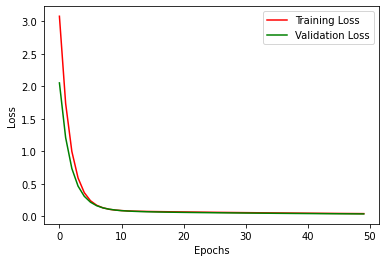

In [14]:
# 作图前 50 个 Epoch 中 Loss 的变化趋势
plt.plot(train_loss_list[:50],'r', label="Training Loss")
plt.plot(val_loss_list[:50],'g', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**比较验证集上 “原始数据点” 和 “模型预测直线” ：**

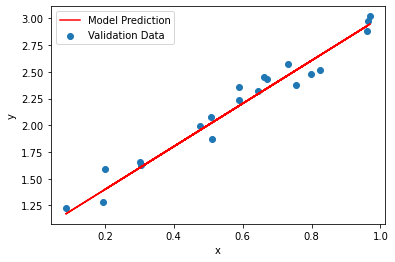

In [15]:
# 利用训练好的模型，对验证集上的 x 进行计算，预测出 y_pred
y_pred = model(x_val_var)  

# Matplotlib 作图。注意，需将计图的 Var 类型转化为 NumPy 数组
plt.scatter(x_val_var.numpy(), y_val_var.numpy(), label="Validation Data")      # 原始数据点
plt.plot(x_val_var.numpy(), y_pred.numpy(), 'r', label="Model Prediction")      # 模型预测结果
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# 📣
恭喜您！已成功完成了线性回归的任务！🎉🎉🎉

您可能觉得这个模型还太过简单、过于理论，无法应用到实际的神经网络训练中。  
那么，请您继续最终章的挑战。  
在终章中，我们会以上述模型为雏形，建立一个健全的神经网络，解决一个实际的分类问题。